In [1]:

import torch

#
import yaml, glob, os, pickle
import torch

import numpy as np

import pandas as pd
from models.stnp import STNP
import matplotlib.pyplot as plt

from utils.data_utils import  FeatureDataset, load_graph_data ,get_filenames
from utils.torch_utils import crps_cdf
from pathlib import Path
MAX_LENGTH=245

In [2]:
def load_model(model, checkpoint_path):
    # x, y, y0= get_tensor(x, y)
    # y_pred= model.generate(x, y0)
    checkpoint= torch.load(checkpoint_path, map_location="cpu")
    model.load_state_dict(checkpoint["state_dict"])
    return model

In [3]:
def get_sample_predictions(model, x_filenames, xt_filenames, y_inc_filenames, y_prev_filenames, y0_filenames, file_id, id2features:dict, n_samples, data_stats:dict, category="test"):
    
    x_filename= x_filenames[file_id]
    xt_filename= xt_filenames[file_id]

    y_inc_filename= y_inc_filenames[file_id]
    y_prev_filename= y_prev_filenames[file_id]
    y0_filename= y0_filenames[file_id]
    
    meta_index=int(os.path.basename(x_filename).split("_")[0])
    
    if category=="test":
        meta_df= pd.read_csv("meta_data/all_meta_df.csv", usecols=["starting_date","seasonality_min", "R0", "Susceptible"])
    elif category=="train":
        meta_df= pd.read_csv("meta_data/x_df.csv", usecols=["starting_date","seasonality_min", "R0", "Susceptible"])
    else:
        raise KeyError
    
    feature= meta_df.iloc[meta_index]
    
    x= np.load(x_filename)
    xt= np.load(xt_filename)
    y_inc= np.load(y_inc_filename)
    y_prev= np.load(y_prev_filename)

    y0=np.load(y0_filename)
    
    xt= xt[:, :MAX_LENGTH, ...]
    y= np.concatenate([y_inc, y_prev], axis=-1)[:, :MAX_LENGTH,...]
    
    xin=np.repeat(x[0][np.newaxis, ...], n_samples, axis=0)
    xt=np.repeat(xt[0][np.newaxis, ...], n_samples, axis=0)

    y0_in= np.repeat(y0[0].reshape(1, -1), n_samples, axis=0)

    samples, mu_y, var_y= model.get_samples(xin, xt, y0_in, data_stats)
    
    return samples, mu_y, var_y, y[:,1:,...], feature

In [4]:
def get_sample_predictions(model, x_filenames, xt_filenames, y_inc_filenames, y_prev_filenames, y0_filenames, file_id, id2features:dict, n_samples, data_stats:dict, category="test"):
    
    x_filename= x_filenames[file_id]
    xt_filename= xt_filenames[file_id]

    y_inc_filename= y_inc_filenames[file_id]
    y_prev_filename= y_prev_filenames[file_id]
    y0_filename= y0_filenames[file_id]
    
    meta_index=int(os.path.basename(x_filename).split("_")[0])
    
    if category=="test":
        meta_df= pd.read_csv("meta_data/all_meta_df.csv", usecols=["starting_date","seasonality_min", "R0", "Susceptible"])
    elif category=="train":
        meta_df= pd.read_csv("meta_data/x_df.csv", usecols=["starting_date","seasonality_min", "R0", "Susceptible"])
    else:
        raise KeyError
    
    feature= meta_df.iloc[meta_index]
    
    x= np.load(x_filename)
    xt= np.load(xt_filename)
    y_inc= np.load(y_inc_filename)
    y_prev= np.load(y_prev_filename)

    y0=np.load(y0_filename)
    
    xt= xt[:, :MAX_LENGTH, ...]
    y= np.concatenate([y_inc, y_prev], axis=-1)[:, :MAX_LENGTH,...]
    
    xin=np.repeat(x[0][np.newaxis, ...], n_samples, axis=0)
    xt=np.repeat(xt[0][np.newaxis, ...], n_samples, axis=0)

    y0_in= np.repeat(y0[0].reshape(1, -1), n_samples, axis=0)

    samples, mu_y, var_y= model.get_samples(xin, xt, y0_in, data_stats)
    
    return samples, mu_y, var_y, y[:,1:,...], feature

In [5]:
params= yaml.load(open("config.yaml", "r"), Loader= yaml.SafeLoader)

In [39]:
checkpoint_file=sorted(list( Path("./logs/checkpoints").glob("*.pt")))[-1]
active_file= sorted(list(Path("./logs/active_logs").glob("*.pk")))[-1]

edge_index, edge_weight= load_graph_data(params["metaPath"])
model= STNP(edge_index, edge_weight, params)
model= load_model(model, checkpoint_file)
with open(active_file, "rb") as fp:
    data_stats= pickle.load(fp)["data_z_scores"]
print(active_file)

logs/active_logs/active_info_iter_0000000196.pk


In [40]:
edge_index, edge_weight= load_graph_data(params["metaPath"])

In [41]:
category= "train"
x_filenames, xt_filenames, y_inc_filenames, y_prev_filenames, y0_filenames= get_filenames(params["dataPath"], category)

In [42]:
with open(os.path.join(params["metaPath"], "id2features.pk"), "rb") as fp:
        id2features= pickle.load(fp)
id2features= dict(id2features)
#
with open(os.path.join(params["metaPath"], "state_map.pk"), "rb") as fp:
    state_map= pickle.load(fp)

In [43]:
file_id= 29
state_id= 4
samples, mu_y, var_y, y_true, feature= get_sample_predictions(model, x_filenames, xt_filenames, y_inc_filenames, y_prev_filenames, y0_filenames, file_id, id2features, n_samples=30, data_stats=data_stats, category=category)

In [44]:

y_inc= np.load(y_inc_filenames[file_id])
y_prev= np.load(y_prev_filenames[file_id])
y0= np.load(y0_filenames[file_id])
x= np.load(x_filenames[file_id])
xt= np.load(xt_filenames[file_id])

y_true_tensor= torch.from_numpy(np.concatenate([y_inc, y_prev], axis=-1))[:, :MAX_LENGTH, ...]
#
x_tensor= torch.from_numpy(x)
xt_tensor= torch.from_numpy(xt)
y0_tensor= torch.from_numpy(y0)





In [45]:
y_dist_hat, mu_hat, var_hat= model.get_samples(x, xt, y0, data_stats)

mu_hat_tensor= torch.from_numpy(mu_hat)
var_hat_tensor= torch.from_numpy(var_hat)

In [46]:
mu_hat.shape, y_true_tensor.shape

((6, 244, 204), torch.Size([6, 245, 204]))

In [47]:
crps, cdf_yhat, yhat_sort, cdf_y_true, y_true_sort= crps_cdf(y_true_tensor[:, 1:, ...], mu_hat_tensor)

In [ ]:
yhat_sort_

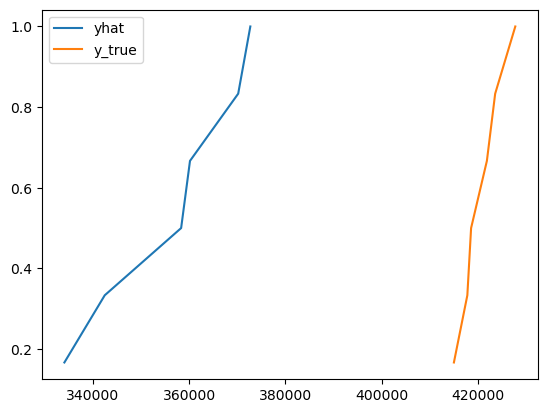

In [51]:
fig, ax= plt.subplots()
ax.plot(yhat_sort[:, 10, 4].detach().numpy(), cdf_yhat[:, 10, 4].detach().numpy(), label="yhat")
ax.plot(y_true_sort[:, 10, 4].detach().numpy(), cdf_y_true[:, 10, 4].detach().numpy(), label='y_true')
plt.legend()

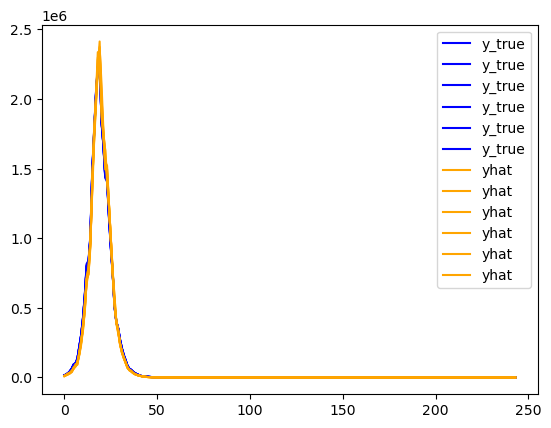

In [53]:
fig, ax= plt.subplots()
_=ax.plot(y_true[:, :, 4].T, label= "y_true", color="blue")
_=ax.plot(mu_hat[:, :, 4].T, label="yhat", color= "orange")
plt.legend()

In [56]:
cdf_yhat_index=torch.searchsorted(cdf_yhat, cdf_y_true)
matching_yhat= y_true_sort[cdf_yhat_index]

In [57]:
matching_yhat.shape

torch.Size([6, 244, 204, 244, 204])

In [58]:
cdf_yhat_index.shape

torch.Size([6, 244, 204])